## Followed this notebook: https://github.com/EmuKit/emukit/blob/main/notebooks/Emukit-tutorial-multi-fidelity.ipynb

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import importlib.util

import GPy
from emukit.multi_fidelity.kernels import LinearMultiFidelityKernel
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [3]:
with open("../coherent/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'

In [4]:
# data processing/setup
if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

In [133]:
data=pd.read_csv(file_in)


LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
LF_sim_noise=np.std(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy())
HF_sim_noise=np.std(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy())

#x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
#row_h=data.index[data['fidelity'] == 1].tolist()
#row_l=data.index[data['fidelity'] == 0].tolist()

#x_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
#y_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy().tolist()

#x_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
#y_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_cnp].to_numpy().tolist()

#x_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
#y_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy().tolist()


# Get the filtered dataframe first
filtered_data = data.loc[(data['fidelity']==1.) & (data['iteration']==0)]

# Select 3 specific indices for training
train_indices = [0, int(186/2), -1]  # 186/2 is the middle of the hf data---will have to update so it's not hardcoded
test_indices = filtered_data.index.difference(filtered_data.iloc[train_indices].index)

# Extract training data
x_train_hf_sim = filtered_data.iloc[train_indices][x_labels].to_numpy().tolist()
y_train_hf_sim = filtered_data.iloc[train_indices][y_label_sim].to_numpy().tolist()

# Extract testing data
x_test_hf_sim = filtered_data.loc[test_indices][x_labels].to_numpy().tolist()
y_test_hf_sim = filtered_data.loc[test_indices][y_label_sim].to_numpy().tolist()

x_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_cnp].to_numpy().tolist()


trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}#, } "mf": [x_train_hf_cnp,y_train_hf_cnp]
noise = {"lf": LF_cnp_noise, "hf": HF_sim_noise*0.001}#, "hf": 0.0}  # why were mf and hf noise originally set to 0?
# noise = {"lf": 1.7e-6, "hf": 1.7e-6}

In [134]:
fidelities = list(trainings_data.keys())
nfidelities = len(fidelities)

In [135]:
x_train = []
y_train = []
for fidelity in fidelities:
    x_tmp=np.atleast_2d(trainings_data[fidelity][0])
    y_tmp=np.atleast_2d(trainings_data[fidelity][1]).T
    x_train.append(x_tmp)
    y_train.append(y_tmp)

X_train, Y_train = convert_xy_lists_to_arrays(x_train, y_train)

In [136]:
num_fidelities = 2  # just lf and hf for now
kernels = [GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1), GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1)]  # since there are two theta parameters, input_dim is 2
linear_mf_kernel = LinearMultiFidelityKernel(kernels)
gpy_linear_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, linear_mf_kernel, n_fidelities = num_fidelities)

# set noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise.fix(noise['lf'])  # lf noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.fix(noise['hf'])  # mf/hf noise

array([0])

In [137]:
## Wrap the model using the given 'GPyMultiOutputWrapper'
lin_mf_model = GPyMultiOutputWrapper(gpy_linear_mf_model, num_fidelities, n_optimization_restarts=10, verbose_optimization=True)

## Fit the model
lin_mf_model.optimize()

Optimization restart 1/10, f = -282.33869988484605
Optimization restart 2/10, f = -282.338699883985
Optimization restart 3/10, f = -297.22307187056737
Optimization restart 4/10, f = -282.33869988399533
Optimization restart 5/10, f = -282.3386998840118
Optimization restart 6/10, f = -282.3387000721198
Optimization restart 7/10, f = -282.338699882923
Optimization restart 8/10, f = -282.3387019291284
Optimization restart 9/10, f = -282.3387036211466
Optimization restart 10/10, f = -282.33869988399016


In [55]:
# First, let's examine the model parameters before and after training
print("=== MODEL DEBUGGING ===")
print(f"Model parameters before training:")
print(gpy_linear_mf_model)
print(f"\nModel parameter values:")
for param_name in gpy_linear_mf_model.parameter_names():
    param_value = gpy_linear_mf_model[param_name]
    print(f"  {param_name}: {param_value}")
print(f"\nData shapes:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_train dtypes: {X_train.dtype}")
print(f"Y_train dtypes: {Y_train.dtype}")

=== MODEL DEBUGGING ===
Model parameters before training:

Name : gp
Objective : 395371.7055947066
Number of Parameters : 7
Number of Optimization Parameters : 5
Updates : True
Parameters:
  gp.                                    |                 value  |  constraints  |  priors
  multifidelity.rbf.variance             |   0.28617117956862426  |      +ve      |        
  multifidelity.rbf.lengthscale          |     0.914916912756707  |      +ve      |        
  multifidelity.rbf_1.variance           |  0.046885728098404036  |      +ve      |        
  multifidelity.rbf_1.lengthscale        |    2.1625230297763776  |      +ve      |        
  multifidelity.scale                    |   -0.1590343866388021  |               |        
  mixed_noise.Gaussian_noise.variance    |                   0.0  |   +ve fixed   |        
  mixed_noise.Gaussian_noise_1.variance  |                   0.0  |   +ve fixed   |        

Model parameter values:
  multifidelity.rbf.variance:   index  |  gp.multi

In [138]:
x_plot = np.linspace(0, 120, 200)[:, None]
x_plot2 = np.hstack((x_plot, x_plot))

X_plot = convert_x_list_to_array([x_plot2, x_plot2])

X_plot_l = X_plot[:len(x_plot2)]
X_plot_h = X_plot[len(x_plot2):]

## Compute mean predictions and associated variance
lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_l)
lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)

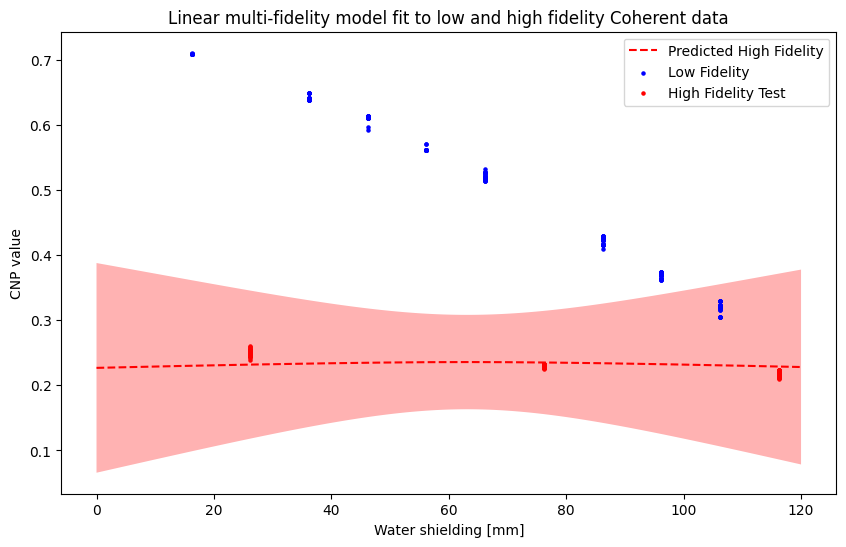

In [12]:
## Plot the posterior mean and variance (water shielding)
plt.figure(figsize=(10, 6))
#plt.fill_between(x_plot.flatten(), (lf_mean_lin_mf_model - 1.96*lf_std_lin_mf_model).flatten(), (lf_mean_lin_mf_model + 1.96*lf_std_lin_mf_model).flatten(), facecolor='b', alpha=0.3)
plt.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='r', alpha=0.3)

#plt.plot(x_plot, lf_mean_lin_mf_model, '--', color='b', label='Predicted Low Fidelity')
plt.plot(x_plot, hf_mean_lin_mf_model, '--', color='r', label='Predicted High Fidelity')
plt.scatter(np.array(x_train_lf_cnp)[:,0], y_train_lf_cnp, color='b', s=5, label='Low Fidelity')
plt.scatter(np.array(x_test_hf_sim)[:,0], y_test_hf_sim, color='r', s=5, label='High Fidelity Test')
plt.xlabel('Water shielding [mm]')
plt.ylabel('CNP value')
plt.legend()
plt.title('Linear multi-fidelity model fit to low and high fidelity Coherent data')
plt.show()

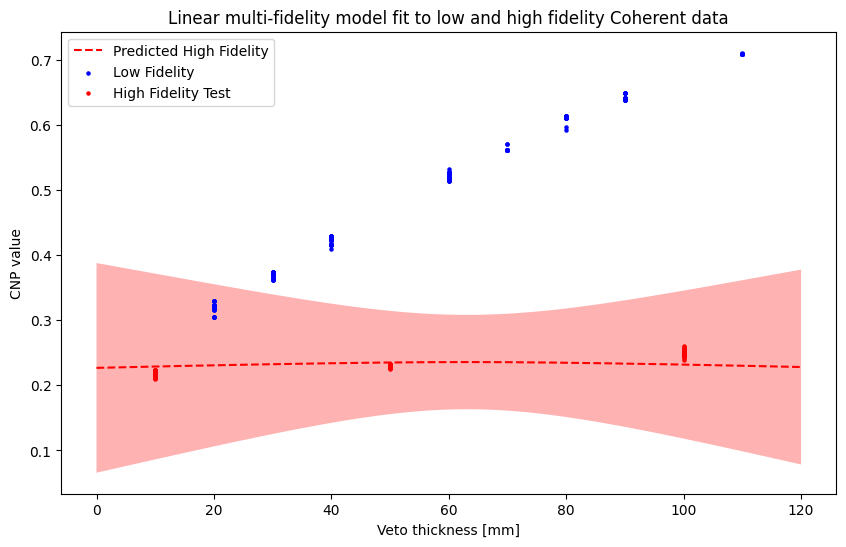

In [13]:
## Plot the posterior mean and variance (veto thickness)
plt.figure(figsize=(10, 6))
#plt.fill_between(x_plot.flatten(), (lf_mean_lin_mf_model - 1.96*lf_std_lin_mf_model).flatten(), (lf_mean_lin_mf_model + 1.96*lf_std_lin_mf_model).flatten(), facecolor='b', alpha=0.3)
plt.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='r', alpha=0.3)

#plt.plot(x_plot, lf_mean_lin_mf_model, '--', color='b', label='Predicted Low Fidelity')
plt.plot(x_plot, hf_mean_lin_mf_model, '--', color='r', label='Predicted High Fidelity')
plt.scatter(np.array(x_train_lf_cnp)[:,1], y_train_lf_cnp, color='b', s=5, label='Low Fidelity')
plt.scatter(np.array(x_test_hf_sim)[:,1], y_test_hf_sim, color='r', s=5, label='High Fidelity Test')
plt.xlabel('Veto thickness [mm]')
plt.ylabel('CNP value')
plt.legend()
plt.title('Linear multi-fidelity model fit to low and high fidelity Coherent data')
plt.show()

In [139]:
# Convert to numpy arrays
x_arr = np.array(x_test_hf_sim)  # your x data
y_arr = np.array(y_test_hf_sim)  # your y values

# Create boolean masks for each group
mask1 = (x_arr[:, 0] == 76.2) & (x_arr[:, 1] == 50.0)
mask2 = (x_arr[:, 0] == 116.2) & (x_arr[:, 1] == 10.0)
mask3 = (x_arr[:, 0] == 26.2) & (x_arr[:, 1] == 100.0)

# Split both x and y data using the same masks
x_group1, y_group1 = x_arr[mask1].tolist(), y_arr[mask1].tolist()
x_group2, y_group2 = x_arr[mask2].tolist(), y_arr[mask2].tolist()
x_group3, y_group3 = x_arr[mask3].tolist(), y_arr[mask3].tolist()

In [140]:
theta_test = np.array([[76.2,50.0,1],[116.2,10.0,1],[26.2,100.0,1]])

hf_mean, hf_var = lin_mf_model.predict(theta_test)
hf_std = np.sqrt(hf_var)

print(f'(76.2, 50.0) mean: {hf_mean[0]}, var: {hf_var[0]}, std: {hf_std[0]}')
print(f'(116.2, 10.0) mean: {hf_mean[1]}, var: {hf_var[1]}, std: {hf_std[1]}')
print(f'(26.2, 100.0) mean: {hf_mean[2]}, var: {hf_var[2]}, std: {hf_std[2]}')

(76.2, 50.0) mean: [0.23080795], var: [2.64837248e-05], std: [0.00514623]
(116.2, 10.0) mean: [0.21723195], var: [2.67719585e-05], std: [0.00517416]
(26.2, 100.0) mean: [0.24668101], var: [2.65418531e-05], std: [0.00515188]


### Plot for (76.2, 50.0) group

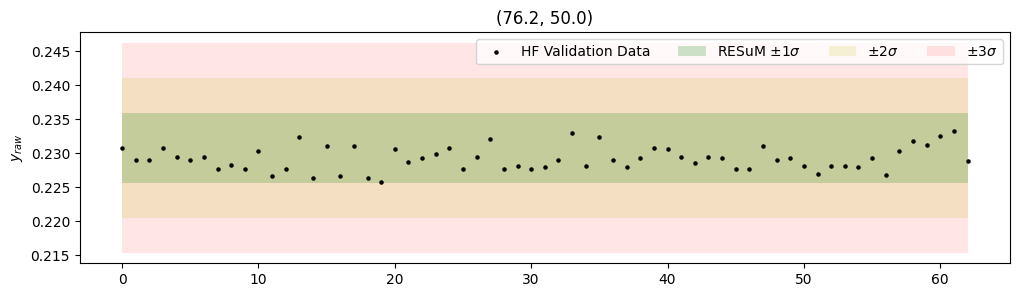

In [141]:
idx_group1 = np.linspace(0, len(x_group1)-1, len(x_group1))
x_plot_g1 = idx_group1[:, None]

vals1 = np.full((len(x_group1), 2), ([76.2,50.0]))
X_plot_g1 = convert_x_list_to_array([vals1, vals1])
X_plot_h_g1 = X_plot_g1[len(vals1):]

## Compute mean predictions and associated variance
hf_mean_lin_mf_model_g1, hf_var_lin_mf_model_g1 = lin_mf_model.predict(X_plot_h_g1)
hf_std_lin_mf_model_g1 = np.sqrt(hf_var_lin_mf_model_g1)

# plotting
plt.figure(figsize=(12, 3))

plt.fill_between(x_plot_g1.flatten(), (hf_mean_lin_mf_model_g1 - 3*hf_std_lin_mf_model_g1).flatten(), (hf_mean_lin_mf_model_g1 + 3*hf_std_lin_mf_model_g1).flatten(), facecolor='r', alpha=0.1, label='$\\pm 3 \\sigma $')
plt.fill_between(x_plot_g1.flatten(), (hf_mean_lin_mf_model_g1 - 2*hf_std_lin_mf_model_g1).flatten(), (hf_mean_lin_mf_model_g1 + 2*hf_std_lin_mf_model_g1).flatten(), facecolor='y', alpha=0.15, label='$\\pm 2 \\sigma $')
plt.fill_between(x_plot_g1.flatten(), (hf_mean_lin_mf_model_g1 - 1*hf_std_lin_mf_model_g1).flatten(), (hf_mean_lin_mf_model_g1 + 1*hf_std_lin_mf_model_g1).flatten(), facecolor='g', alpha=0.2, label='RESuM $\\pm 1 \\sigma $')

plt.scatter(idx_group1, y_group1, color='k', s=5, label='HF Validation Data')
#plt.xlabel('Point index')
plt.ylabel('$y_{raw}$')
plt.title('(76.2, 50.0)')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=4, loc='upper right')

plt.show()

### Plot for (116.2, 10.0) group

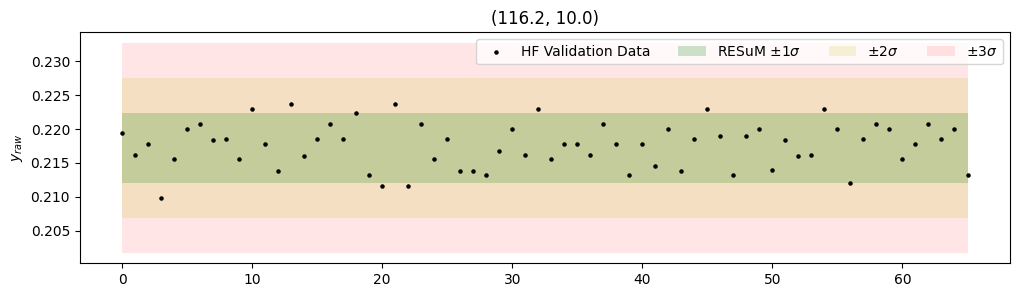

In [142]:
idx_group2 = np.linspace(0, len(x_group2)-1, len(x_group2))
x_plot_g2 = idx_group2[:, None]

vals2 = np.full((len(x_group2), 2), ([116.2,10.0]))
X_plot_g2 = convert_x_list_to_array([vals2, vals2])
X_plot_h_g2 = X_plot_g2[len(vals2):]

## Compute mean predictions and associated variance
hf_mean_lin_mf_model_g2, hf_var_lin_mf_model_g2 = lin_mf_model.predict(X_plot_h_g2)
hf_std_lin_mf_model_g2 = np.sqrt(hf_var_lin_mf_model_g2)

# plotting
plt.figure(figsize=(12, 3))

plt.fill_between(x_plot_g2.flatten(), (hf_mean_lin_mf_model_g2 - 3*hf_std_lin_mf_model_g2).flatten(), (hf_mean_lin_mf_model_g2 + 3*hf_std_lin_mf_model_g2).flatten(), facecolor='r', alpha=0.1, label='$\\pm 3 \\sigma $')
plt.fill_between(x_plot_g2.flatten(), (hf_mean_lin_mf_model_g2 - 2*hf_std_lin_mf_model_g2).flatten(), (hf_mean_lin_mf_model_g2 + 2*hf_std_lin_mf_model_g2).flatten(), facecolor='y', alpha=0.15, label='$\\pm 2 \\sigma $')
plt.fill_between(x_plot_g2.flatten(), (hf_mean_lin_mf_model_g2 - 1*hf_std_lin_mf_model_g2).flatten(), (hf_mean_lin_mf_model_g2 + 1*hf_std_lin_mf_model_g2).flatten(), facecolor='g', alpha=0.2, label='RESuM $\\pm 1 \\sigma $')

plt.scatter(idx_group2, y_group2, color='k', s=5, label='HF Validation Data')
plt.ylabel('$y_{raw}$')
plt.title('(116.2, 10.0)')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=4, loc='upper right')

plt.show()

### Plot for (26.2, 100.0) group

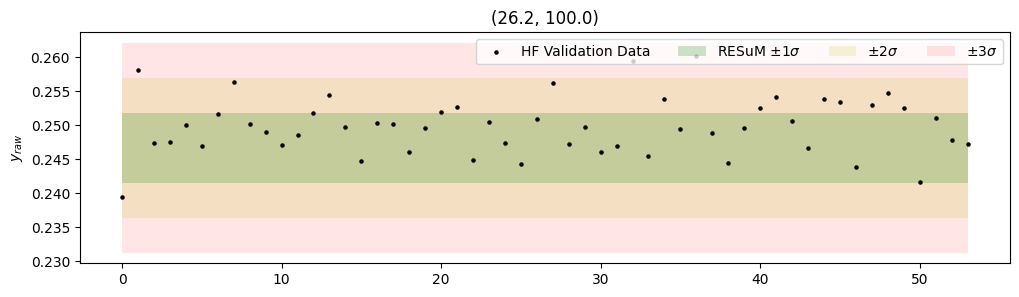

In [143]:
idx_group3 = np.linspace(0, len(x_group3)-1, len(x_group3))
x_plot_g3 = idx_group3[:, None]

vals3 = np.full((len(x_group3), 2), ([26.2,100.0]))
X_plot_g3 = convert_x_list_to_array([vals3, vals3])
X_plot_h_g3 = X_plot_g3[len(vals3):]

## Compute mean predictions and associated variance
hf_mean_lin_mf_model_g3, hf_var_lin_mf_model_g3 = lin_mf_model.predict(X_plot_h_g3)
hf_std_lin_mf_model_g3 = np.sqrt(hf_var_lin_mf_model_g3)

# plotting
plt.figure(figsize=(12, 3))

plt.fill_between(x_plot_g3.flatten(), (hf_mean_lin_mf_model_g3 - 3*hf_std_lin_mf_model_g3).flatten(), (hf_mean_lin_mf_model_g3 + 3*hf_std_lin_mf_model_g3).flatten(), facecolor='r', alpha=0.1, label='$\\pm 3 \\sigma $')
plt.fill_between(x_plot_g3.flatten(), (hf_mean_lin_mf_model_g3 - 2*hf_std_lin_mf_model_g3).flatten(), (hf_mean_lin_mf_model_g3 + 2*hf_std_lin_mf_model_g3).flatten(), facecolor='y', alpha=0.15, label='$\\pm 2 \\sigma $')
plt.fill_between(x_plot_g3.flatten(), (hf_mean_lin_mf_model_g3 - 1*hf_std_lin_mf_model_g3).flatten(), (hf_mean_lin_mf_model_g3 + 1*hf_std_lin_mf_model_g3).flatten(), facecolor='g', alpha=0.2, label='RESuM $\\pm 1 \\sigma $')

plt.scatter(idx_group3, y_group3, color='k', s=5, label='HF Validation Data')
plt.ylabel('$y_{raw}$')
plt.title('(26.2, 100.0)')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=4, loc='upper right')

plt.show()